<a href="https://colab.research.google.com/github/jaderAdriel/Clorofila-a/blob/main/Projeto_pibic_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Bilbiotecas { display-mode: "form" }
!pip install --upgrade gspread
!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from gspread import *
import numpy as np

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [181]:
#@title Insira a url da panilha e o nome do reservatorio e o parâmetro { run: "auto", form-width: "50%", display-mode: "form" }

url1 = "https://docs.google.com/spreadsheets/d/16gMgMV5wRAF83w7i_q9JwA03kGQprFkMjQojLgNDVtA/edit?usp=sharing" #@param {type:"string"}
reservatory1 = "CND-CER-002" #@param {type:"string"}
url2 = "https://docs.google.com/spreadsheets/d/1xK1tuD3eTHktwVzsmqZEcFKcjut-eak2E21AxtdTUek/edit?ouid=115855923033913247098&usp=sheets_home&ths=true" #@param {type:"string"}
reservatory2 = "LES-IGP-001" #@param {type:"string"}



In [224]:
#@title  { form-width: "50%" }
#@markdown Select if you want compare parametes on the same reservoirs, compare same parameter on diferents reservoirs or dont compare
compare = "Parameters" #@param ["Parameters", "Reservoirs", "None"]
parameter1 = "N Total" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]
#@markdown only if you selected parameters option in 'compare' :) 
parameter2 = "N-NH3" #@param ["Clorofila a", "Colif. termo", "Condutividade", "Salinidade", "Sólidos em suspensão", "Sólidos totais", "STD", "Temperatura", "Turbidez", "Alcalinidade total", "DBO", "DQO", "Nitrogênio Nitrato", "N-NH3", "N Total", "OD", "pH", "P Total", "% Saturação de Oxigênio Dissolvido", "Cloreto", "Ortofosfato solúvel", "Temperatura do Ar", "Transparência da Água"]


In [219]:
#@title Gŕafico { run: "auto", form-width: "50%", display-mode: "form" }
#@markdown Select the reservoir, ignore if you are going to compare both 
graph = "reservoir2" #@param ["reservoir1", "reservoir2"]
#@markdown select the period you want
startDate = "2015-03-01" #@param {type:"date"}
finalDate = "2022-12-25" #@param {type:"date"}
variable_name = 5



In [217]:
#@title Functions { form-width: "20%", display-mode: "form" }

def month_name(mes):
    x = {
        '01': 'Janeiro','02': 'Fevereiro','03': 'Março','04': 'Abril',
        '05': 'Maio','06': 'Junho','07': 'Julho','08': 'Agosto','09': 'Setembro',
        '10': 'Outubro','11': 'Novembro','12': 'Dezembro'
        }
    return x[mes]


def select(startDate, finalDate, dic):

    selectedDic = []

    startYear = startDate.split('-')[0]
    startMonth= startDate.split('-')[1]
    finalYear = finalDate.split('-')[0]
    finalMonth= finalDate.split('-')[1]

    for campaign in dic:
        day, month, year = campaign['COLETA'].split('/')
        periodo = year + month

        if startYear+startMonth <= periodo <= finalYear+finalMonth: 
            selectedDic.append(campaign)

        # if not( startMonth <= month <= finalMonth ): continue;
        # if not( startYear <= year <= finalYear ): continue;
        # selectedDic.append(campaign)
        

    return selectedDic

def valid_value(value):
    
    validValue = ''
    value = str(value)

    for i in value:
        if i == ',': validValue += '.';
        elif i == '<': validValue += '';
        else: validValue += i;

    try: return float(validValue)
    except: return value


def get_parameter(parameter, worksheets):
    
    worksheet = worksheets.get_worksheet(0)
    collectionDates = worksheets.get_worksheet(1)
    dic = []
    dates =  {}

    for campanha, date in collectionDates.get_all_values():
        dates[campanha] = date

    for cell in worksheet.get_all_values():
        if parameter in cell :
            campanha = {}
            campanha['NOME'] = cell[1]
            campanha['UNIDADE'] = cell[3]
            campanha['VALOR'] = valid_value(cell[-1])
            campanha['COLETA'] = dates[cell[-2]]

            dic.append(campanha)

    return dic

In [226]:
#@title Graph { form-width: "20%" }

def compareReservoirs(dic1, dic2, reservatory1, reservatory2, ylabel = ''):
    
    subplot1 = []
    subplot2 = []
    anos = []
    x = []

    for campanha1 in dic1:
        dia1, mes1, ano1 = campanha1['COLETA'].split('/')
        for campanha2 in dic2:
            dia2, mes2, ano2 = campanha2['COLETA'].split('/')
            if mes1 == mes2 and ano1 == ano2:
                subplot1.append(campanha1['VALOR'])
                subplot2.append(campanha2['VALOR'])
                data = month_name(mes1) + ' ' + ano1
                if ano1 not in anos: anos.append(ano1)
                x.append(data)
                break

    plt.figure(figsize=(15, 3))

    plt.plot(x, subplot1, color='r', label='sin') 
    plt.plot(x, subplot2, color='b', label='cos') 
 
    plt.scatter(x, subplot1, color='red')
    plt.scatter(x, subplot2, color='blue')
    plt.title(f'{reservatory1} X {reservatory2}')
    plt.ylabel(dic1[0]['UNIDADE'])
    plt.autoscale(axis = 'x', tight=True)
    plt.xticks(rotation = 30)

    plt.legend([reservatory1, reservatory2])

    return 


def compareParameter(dic1, dic2, reservatory1):
    subplot1 = []
    subplot2 = []
    parameter1 = dic1[0]['NOME']
    parameter2 = dic2[0]['NOME']
    unidade1 = dic1[0]['UNIDADE']
    unidade2 = dic2[0]['UNIDADE']
    x = []
    x1 = []

    for i, campanha1 in enumerate(dic1):
        day, month, year = campanha1['COLETA'].split('/')
        subplot1.append(campanha1['VALOR'])
        try: subplot2.append(dic2[i]['VALOR'])
        except: break
        date = month_name(month) + ' ' + year
        x.append(date)

    plt.plot(x, subplot1, color='r', label='sin') 
    plt.plot(x, subplot2, color='b', label='cos') 
 
    plt.scatter(x, subplot1, color='red')
    plt.scatter(x, subplot2, color='blue')

    plt.gcf().set_size_inches(15, 6)
    plt.autoscale(axis = 'x', tight=True)
    plt.xticks(rotation = 30)
    plt.title(f'{parameter1} x {parameter2}')
    plt.legend([parameter1, parameter2])
    plt.ylabel(f'{parameter1}({unidade1}) - {parameter1}({unidade1})')
    

    return 


def lineGraph(dic, reservoir = 'x'):
    parameter = dic[0]['NOME']
    unidade = dic[0]['UNIDADE']
    x = []
    y = []

    for campaign in dic:
        y.append(campaign['VALOR'])
        date = campaign['COLETA'].split('/')
        date = month_name(date[1]) + ' ' + date[2]
        x.append(date)

    plt.gcf().set_size_inches(15, 5)
    plt.autoscale(axis = 'x', tight=True)
    plt.xticks(rotation = 40)
    plt.title(f'{parameter} in {reservoir}')
    plt.ylabel(unidade)
    plt.plot(x, y, color='blue')
    plt.scatter(x, y, color='blue')


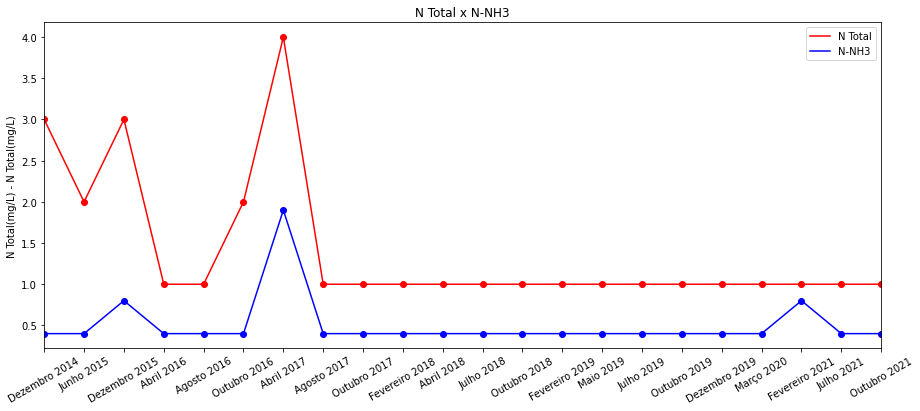

In [227]:
#@title Run { form-width: "10%" }
url = url1 if graph == "reservoir1" else url2
reservoir = reservatory1 if graph == "reservoir1" else reservatory2
if compare == 'None':
    dics = [gc.open_by_url(url)]
    dics[0] = get_parameter(parameter1, dics[0])
    dics[0] = select(startDate, finalDate, dics[0])
    lineGraph(dics[0], reservoir)

if compare == 'Reservoirs': 
    dics = [gc.open_by_url(url1), gc.open_by_url(url2)]
    dics[0] = select(startDate, finalDate ,get_parameter(parameter1, dics[0]))
    dics[1] = select(startDate, finalDate ,get_parameter(parameter1, dics[1]))
    print(dics[0] == dics[1])
    compareReservoirs(dics[0], dics[1], reservatory1, reservatory2)
    
    
elif compare == 'Parameters':
    dics = [gc.open_by_url(url1), gc.open_by_url(url1)]
    dics[0] = select(startDate, finalDate ,get_parameter(parameter1, dics[0]))
    dics[1] = select(startDate, finalDate ,get_parameter(parameter2, dics[1]))
    compareParameter(dics[0], dics[1], reservatory1)